# Setup

In [9]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

TORCH, CUDA = torch.__version__.split('+')

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric gdown sklearn matplotlib networkx rich

Looking in links: https://data.pyg.org/whl/torch-1.13.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cpu.html


In [2]:
import numpy as np
import torch
import os
import gdown
from torch_geometric.data import InMemoryDataset, Data, Batch

import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


class CosmicRayDS(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ["cr_sphere.npz"]

    @property
    def processed_file_names(self):
        return ["data.pt"]

    def download(self):
        url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1XKN-Ik7BDyMWdQ230zWS2bNxXL3_9jZq"
        if os.path.exists(self.raw_file_names[0]) == False:
            gdown.download(url, self.raw_file_names[0], quiet=True)

    def process(self):
        f = np.load(self.raw_file_names[0])
        x = torch.tensor(f["data"]).float()
        y = torch.tensor(f["label"]).float()
        data_list = []
        for idx in range(len(x)):
            data_list.append(
                Data(x=x[idx, :, 3].reshape(-1, 1), pos=x[idx, :, :3], y=y[idx])
            )
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


ds = CosmicRayDS(".").shuffle()


 # 1 Graph Handling
 For this exercise we will learn to use `pytorch_geometric` (PyG) to run GNNs.
 The library comes with a comprehensive [documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html) and not only provides tools to handle graphs but also provides a large set of GNN specific layers and dataset.

 ## Task 1.1
 [Data Handling of Graphs](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-handling-of-graphs) offers a nice introduction into handling graphs.
 Provide an adjacency matric for cyclic graph (each nodes connects to the next) with 5 nodes. Convert the adjacency matric to an edge_index. With this edge_index implement a graph with features [0,1,...,n-1]:

In [3]:
from torch_geometric.data import Data, Batch
from torch_geometric.utils import dense_to_sparse

adj = torch.tensor(
    [
        [
            [0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0],
            [1.0, 0.0, 0.0, 0.0, 0.0],
        ]
    ]
)

cycle = Data(
    x=torch.tensor(range(5)),
    edge_index=dense_to_sparse(adj)[0],
)

 ## Task 1.2
 Implement binary tree with 7 nodes over three levels directly constructing the edge_index.:
    0
  1   2
 3 4 5 6

In [4]:
tree = Data(
    x=torch.tensor(range(7)),
    edge_index=torch.tensor([[0, 1], [0, 2], [1, 3], [1, 4], [2, 5], [2, 6]]).T,
)

 ## Task 1.3
 Convert the implemented PyG graphs to `networkx` graphs and plot them.

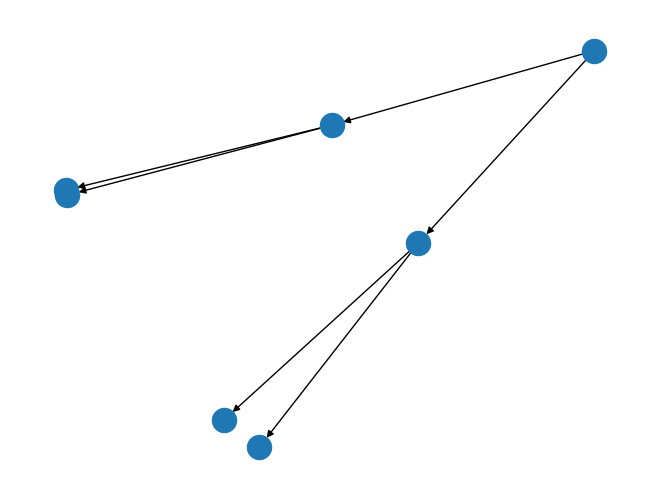

In [5]:
from torch_geometric.utils import to_networkx
import networkx as nx

nx.draw_kamada_kawai(to_networkx(tree))

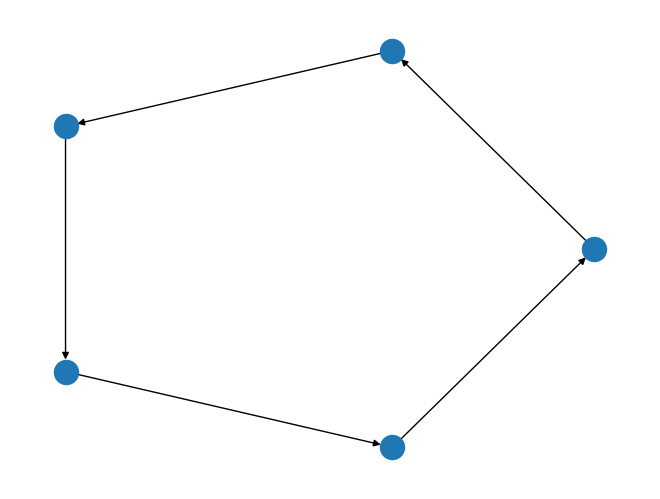

In [6]:
nx.draw_kamada_kawai(to_networkx(cycle))

## Task 1.4
Providing Graphs to Neural Networks significantly differs from providing regular tensors.
Not only do we need two matrices to represent a graph, but the size of the graph may also vary.
This makes batching very different for graphs. PyG builds batches of graphs by combining them into a single, disconnected graph.
Have a look at the documentation on [Mini-batches](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#mini-batches).

Batch the two graphs together and plot the batch with `networkx`. What do you see?

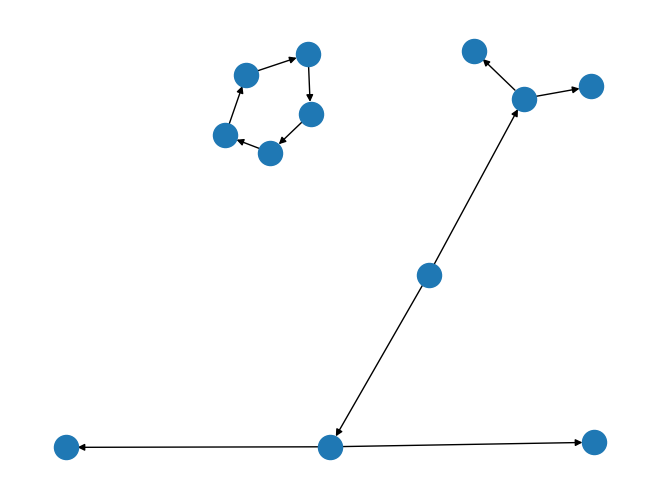

In [22]:
batch = Batch.from_data_list([tree, cycle])
G=to_networkx(batch)
nx.draw_spring(G)

# -> The Graphs are combined to a larger graph.

 ## Task 1.5
 Inspect the properties of the batch.
 You can use the `inspect` method of the rich library or a simple `print`.
 What do the `batch` and `ptr` attributes do?

In [16]:
import rich
rich.inspect(batch)
# -> `batch` provides the index for teh feature  matrix of each graph in the feature vector of the batch
# -> `ptr` does the same, but with a range

/home/mscham/deep-learning-physics/venv/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'num_faces' is deprecated, use 'data.face.size(-1)' instead
  warnings.warn(out)


╭────────────────────────── DataBatch(x=[12], edge_index=[2, 11], batch=[12], ptr=[3]) ───────────────────────────╮
│ def (*args: List[str]) -> Iterable:                                                                             │
│                                                                                                                 │
│             batch = tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])                                                │
│         edge_attr = None                                                                                        │
│        edge_index = tensor([[ 0,  0,  1,  1,  2,  2,  7,  8,  9, 10, 11],                                       │
│                             [ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11,  7]])                                      │
│       edge_stores = [                                                                                           │
│                         {'x': tensor([0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4]), 'edge_index': tensor([[ 0,  0,  1,  │
│                     1,  2,  2,  7,  8,  9, 10, 11],                                                             │
│                             [ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11,  7]]), 'batch': tensor([0, 0, 0, 0, 0, 0,  │
│                     0, 1, 1, 1, 1, 1]), 'ptr': tensor([ 0,  7, 12])}                                            │
│                     ]                                                                                           │
│       edge_weight = None                                                                                        │
│           is_cuda = False                                                                                       │
│              keys = ['batch', 'x', 'edge_index', 'ptr']                                                         │
│       node_stores = [                                                                                           │
│                         {'x': tensor([0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4]), 'edge_index': tensor([[ 0,  0,  1,  │
│                     1,  2,  2,  7,  8,  9, 10, 11],                                                             │
│                             [ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11,  7]]), 'batch': tensor([0, 0, 0, 0, 0, 0,  │
│                     0, 1, 1, 1, 1, 1]), 'ptr': tensor([ 0,  7, 12])}                                            │
│                     ]                                                                                           │
│ num_edge_features = 0                                                                                           │
│         num_edges = 11                                                                                          │
│         num_faces = None                                                                                        │
│      num_features = 1                                                                                           │
│        num_graphs = 2                                                                                           │
│ num_node_features = 1                                                                                           │
│         num_nodes = 12                                                                                          │
│               pos = None                                                                                        │
│            stores = [                                                                                           │
│                         {'x': tensor([0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4]), 'edge_index': tensor([[ 0,  0,  1,  │
│                     1,  2,  2,  7,  8,  9, 10, 11],                                                             │
│                             [ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11,  7]]), 'batch': tensor([0, 0, 0, 0, 0, 0,  │
│                     0, 1, 1, 1, 1, 1]), 'ptr': tensor(

 Adapted from https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

 # 2 Introduction: Hands-on Graph Neural Networks

 Recently, deep learning on graphs has emerged to one of the hottest research fields in the deep learning community.
 Here, **Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.

 This is done by following a simple **neural message passing scheme**, where node features $\mathbf{x}_v^{(\ell)}$ of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(v)$:

 $$
 \mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
 $$

 This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.
 PyTorch Geometric is an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/), and consists of various methods and utilities to ease the implementation of Graph Neural Networks.

 Following [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907), let's dive into the world of GNNs by looking at a simple graph-structured example, the well-known [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.

 PyTorch Geometric provides an easy access to this dataset via the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage:

In [17]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


 After initializing the [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) dataset, we first can inspect some of its properties.
 For example, we can see that this dataset holds exactly **one graph**, and that each node in this dataset is assigned a **34-dimensional feature vector** (which uniquely describes the members of the karate club).
 Furthermore, the graph holds exactly **4 classes**, which represent the community each node belongs to.

 Let's now look at the underlying graph in more detail:

In [18]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


 Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
 We can print the data object anytime via `print(data)` to receive a short summary about its attributes and their shapes:
 ```
 Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
 ```
 We can see that this `data` object holds 4 attributes:
 1. The `edge_index` property holds the information about the **graph connectivity**, *i.e.*, a tuple of source and destination node indices for each edge.
 2. The **node features** `x` (each of the 34 nodes is assigned a 34-dim feature vector)
 3. The **node labels**  `y` (each node is assigned to exactly one class).
 4. There also exists an additional attribute called `train_mask`, which describes for which nodes we already know their community assigments.
 In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

 ## Task 2.1
 Plot the network graph.
 Color the nodes according to their class.

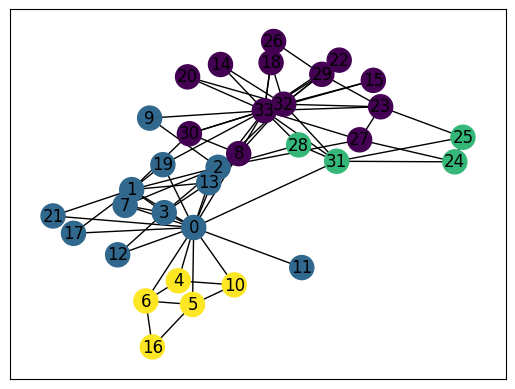

In [19]:
from torch_geometric.utils import to_networkx
import networkx as nx

G = to_networkx(data, to_undirected=True)
nx.draw_networkx(
    G, pos=nx.spring_layout(G), node_color=data.y
)

 ## Task 2.2 - Implementing Graph Neural Networks

 After learning about PyG's data handling, it's time to implement our first Graph Neural Network!

 For this, we will use on of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

 $$
 \mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
 $$

 where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

 PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

 With this, we are ready to create our first Graph Neural Network by defining our network architecture in a `torch.nn.Module` class:

In [20]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        # Apply a final (linear) classifier.
        out = self.classifier(h)
        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


 Here, we first initialize all of our building blocks in `__init__` and define the computation flow of our network in `forward`.
 We first define and stack **three graph convolution layers**, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away).
 In addition, the `GCNConv` layers reduce the node feature dimensionality to $2$, *i.e.*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh) non-linearity.

 After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

 We return both the output of the final classifier as well as the final node embeddings produced by our GNN.
 We proceed to initialize our final model via `GCN()`, and printing our model produces a summary of all its used sub-modules.


 ### Embedding the Karate Club Network

 Let's take a look at the node embeddings produced by our GNN before training it.
 Pass in the initial node features `x` and the graph connectivity information `edge_index` to the model, and visualize its 2-dimensional embedding.

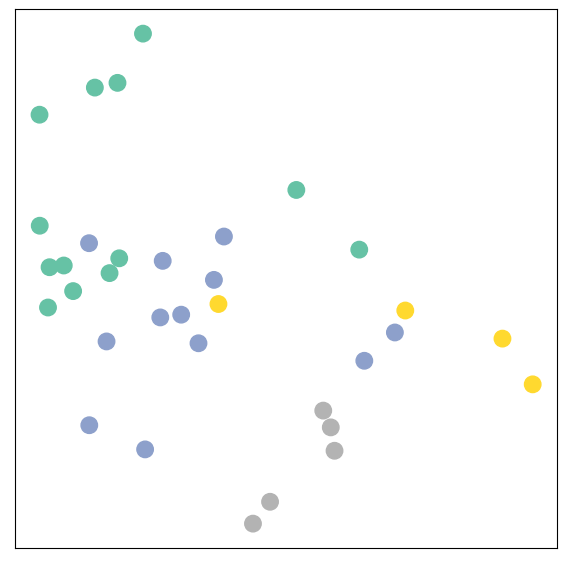

In [21]:
import matplotlib.pyplot as plt

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()


model = GCN()

_, h = model(data.x, data.edge_index)
visualize_embedding(h, color=data.y)

 Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.
 Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
 This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

 ## Task 2.3 Training on the Karate Club Network

 But can we do better? Let's look at an example on how to train our network parameters based on the knowledge of the community assignments of 4 nodes in the graph (one for each community):

 Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observe how the embeddings react.
 Here, we make use of a semi-supervised or transductive learning procedure: We simply train against one node per class, but are allowed to make use of the complete input graph data.

 Training our model is very similar to any other PyTorch model.
 In addition to defining our network architecture, we define a loss critertion (here, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and initialize a stochastic gradient optimizer (here, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
 After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.


 Note that our semi-supervised learning scenario is achieved by the following line:
 ```
 loss = criterion(out[data.train_mask], data.y[data.train_mask])
 ```
 While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.
 Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

 Let us now start training and see how our node embeddings evolve over time (best experienced by explicitely running the code):

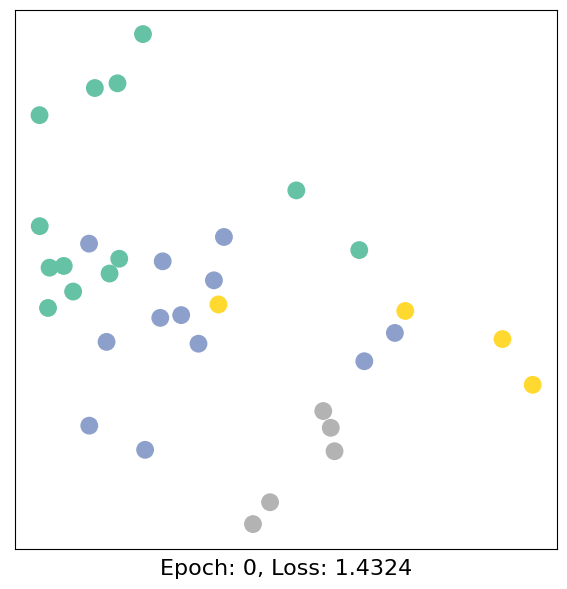

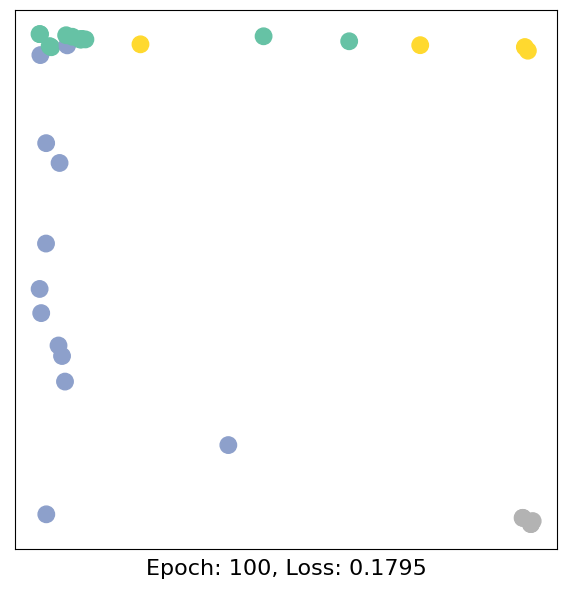

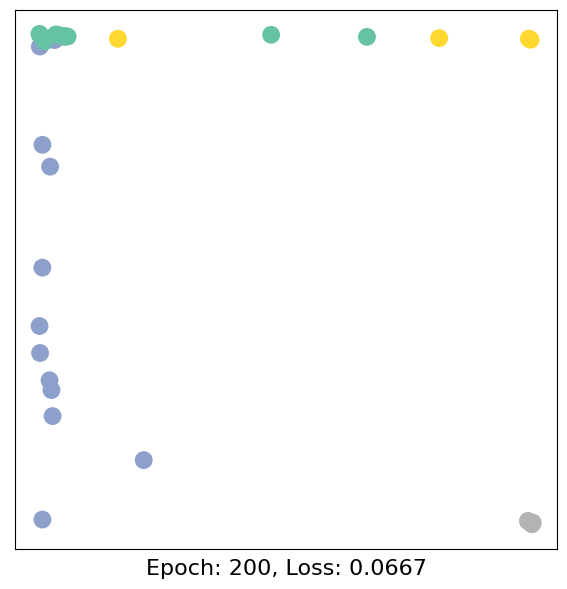

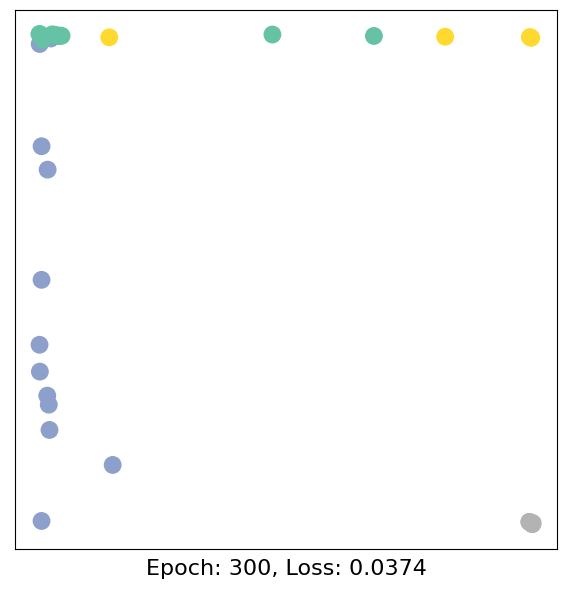

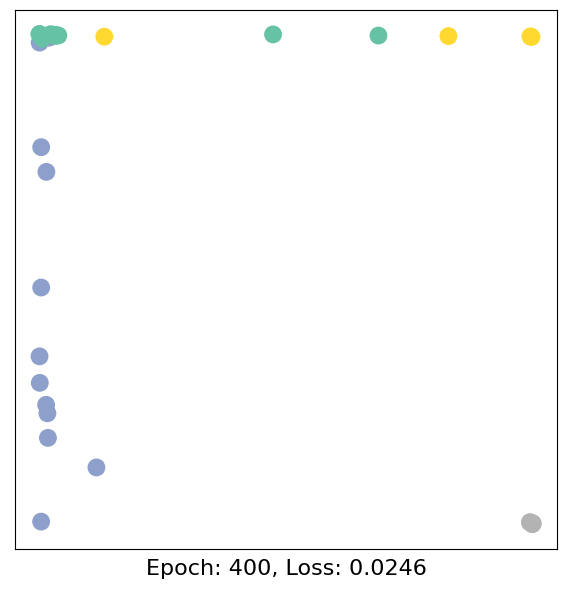

In [22]:
import time
from IPython.display import Javascript,display_javascript  # Restrict height of output cell.
display_javascript(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    # Clear gradients.
    optimizer.zero_grad()  
    # Perform a single forward pass.
    out, h = model(data.x, data.edge_index)  
    # Compute the loss solely based on the training nodes.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 100 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)

 What do you notice when looking at the embedding?

 -> The model separates the communities into the corners if the embedding space, classifying most of the nodes correctly.

## 3 Signal Classification using Dynamic Graph Convolutional Neural Networks
After a long journey through the universe before reaching the earth, the cosmic particles interact with the galactic magnetic field $B$.
As these particles carry a charge $q$ they are deflected in the field by the Lorentz force $F = q \cdot v × B$.
Sources of cosmic particles are located all over the sky, thus arrival distributions of the cosmic particles are isotropic in general. However, particles originating from the same source generate on top of the isotropic arrival directions, street-like patterns from galactic magnetic field deflections.
In this tasks we want to classify whether a simulated set of $500$ arriving cosmic particles contains street-like patterns (signal), or originates from an isotropic background.
Training graph networks can be computationally demanding, thus, we recommend to use a GPU for this task.

 Adapted from https://github.com/DeepLearningForPhysicsResearchBook/deep-learning-physics/blob/main/Exercise_10_1.ipynb

In [23]:
import torch
from torch import nn
from torch_geometric.data import Data, Batch
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

n_test = 10000
ds_train, ds_test = ds[:-n_test], ds[-n_test:]

Make sure to have a GPU selected for this exercise:
Runtime > Change Runtime > Hardware accelerator > GPU  

 ## Task 3.1
 Extract a single event from the test dataset and inspect it.
 Plot an example sky map using the `skymap` function from `utils`

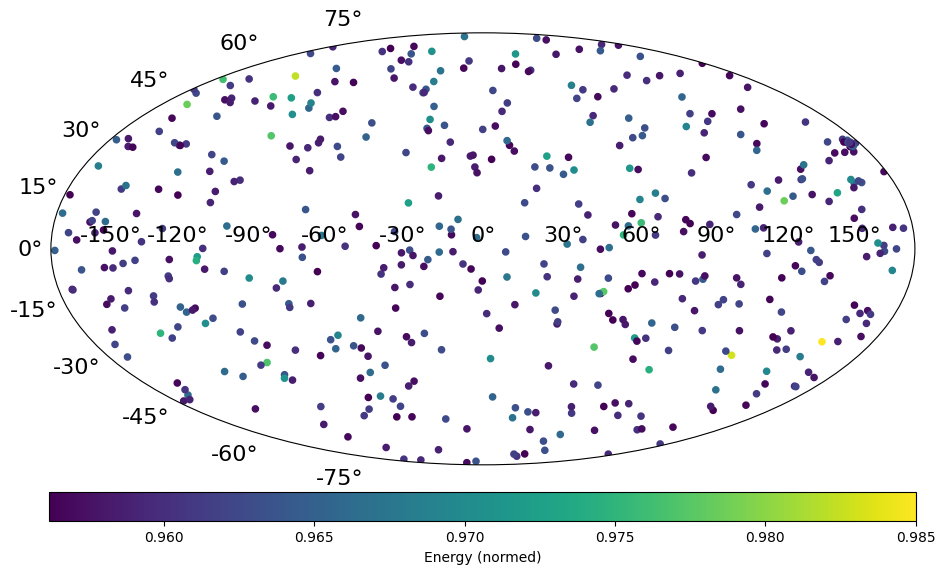

In [24]:
def vec2ang(v):
    x, y, z = np.asarray(v).T
    phi = np.arctan2(y, x)
    theta = np.arctan2(z, (x * x + y * y) ** 0.5)
    return np.vstack([phi, theta]).T

def skymap(v, c=None, edge_index=None, zlabel="", title="", **kwargs):
    pos_ang= vec2ang(v)
    lons, lats = pos_ang.T
    lons = -lons
    fig = plt.figure(figsize=kwargs.pop("figsize", [12, 6]))
    ax = fig.add_axes([0.1, 0.1, 0.85, 0.9], projection="hammer")
    events = ax.scatter(lons, lats, c=c, s=12, lw=2)
    
    if edge_index is not None:
        x = pos_ang[:,0][edge_index]
        y = pos_ang[:,1][edge_index]
        ax.plot(-x,y, linestyle='-', linewidth=.5)

    plt.colorbar(
        events, orientation="horizontal", shrink=0.85, pad=0.05, aspect=30, label=zlabel
    )
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return fig



event0 = ds_test[0]
fig = skymap(event0.pos, c=event0.x, zlabel="Energy (normed)", title="Event 0")

 ## Task 3.2
 Generate edges for the event using `knn_graph`.
 Plot the edges by passing the `edge_index` to the `skymap` function. How does the number of edges scale with the $k$?

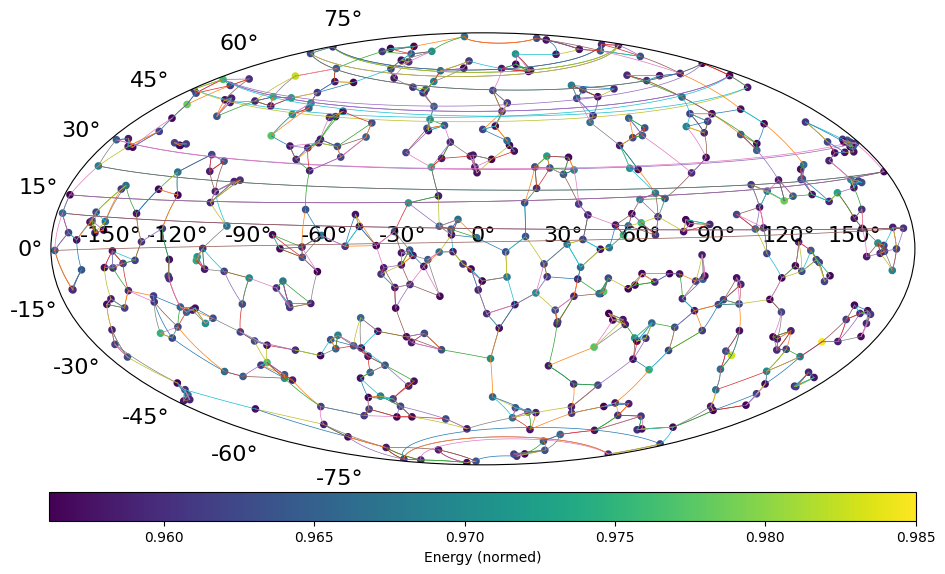

In [25]:
from torch_geometric.nn import knn_graph


fig = skymap(
    event0.pos,
    c=event0.x,
    edge_index=knn_graph(event0.pos, k=3),
    zlabel="Energy (normed)",
    title="Event 0",
)
# -> k*num_nodes

 ## Task 3.3
 Write a class to return a simple Feed-Forward-Network (FFN) for a given number inputs and outputs. (3 layers, 20 hidden nodes, BatchNorm, LeakyReLU)
 The final layer has neither activation nor norm.

In [26]:
class FFN(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=20):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.LeakyReLU(0.1),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.LeakyReLU(0.1),
            nn.Linear(n_hidden, n_out),
        )

    def forward(self, *args, **kwargs):
        return self.seq(*args, **kwargs)

 ## Task 3.4
 GNNs classifiers are frequently build in a two step process: First MessagePassingLayers( aka Graph [Convolutional Layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers) ) update the nodes. These exploit the local information. Then, the nodes are aggregated using [Pooling Layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#pooling-layers), reducing the graph to a single feature vector. This feature vector is then passed through a FFN to get the classification output.
 Have a look at the documentation of [EdgeConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.EdgeConv) and [DynamicEdgeConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.DynamicEdgeConv).
 What is the difference?
 -> `EdgeConv` requires a `edge_index` while `DynamicEdgeConv` constructs the `edge_index` on the feature space.
 What the input space of the `nn` passed to EdgeConv?
 -> 2* num_features
 Implement a GNN class with three MPL (not MLP!) using EdgeConv
 and DynamicEdgeConv. For the first MPL, we want to construct
 the `edge_index` on the feature space.
 Use both the energies of the particles (`batch.x`) as well as their positions (`batch.pos`) as an input to the first MPL.
 For the other two layer we may (or may not) choose to construct the `edge_index` on the feature space.
 > Sidenote: Running `knn` multiple times per forward-pass might be quite expensive, depending on the number of nodes and the dimensionality of the space.
 After the MPLs apply a `global_X_pool` and pass the result through a FFN projecting to a single node.

In [27]:
from torch_geometric.nn import knn_graph, EdgeConv, DynamicEdgeConv, global_add_pool


class GNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = EdgeConv(FFN(4 * 2, 5))
        self.conv2 = DynamicEdgeConv(FFN(5 * 2, 5), k=5)
        self.conv3 = DynamicEdgeConv(FFN(5 * 2, 5), k=5)
        self.out = FFN(5, 1)

    def forward(self, batch: Batch):
        # We run knn on the positions
        # knn needs to know about the batches, otherwise it connects
        # points from different events
        edge_index = knn_graph(batch.pos, batch=batch.batch, k=10)
        x = torch.hstack([batch.x, batch.pos])
        x = self.conv1(x, edge_index=edge_index)
        x = self.conv2(x)
        # edge_index = knn_graph(x, batch=batch.batch, k=10)
        x = self.conv3(x)
        x = global_add_pool(x, batch.batch)
        x = self.out(x)
        return x.squeeze()

 ## Task 3.5
 Fill in  the gaps to implement a training loop.
 > The [`BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) is recommended as it combines a Sigmoid layer and the `BCELoss`.

In [28]:
from collections import defaultdict
class MetricAggr:
    def __init__(self, log_interval: int = 20) -> None:
        self.log_interval = log_interval
        self.storage = defaultdict(list)

    def __call__(self, val_name: str, val):
        val_store = self.storage[val_name]
        val_store.append(val)
        if len(val_store) == self.log_interval:
            print(f"{val_name}: {np.mean(val_store)}")
            self.storage[val_name] = []
metric_aggr = MetricAggr()

In [31]:
from torch_geometric.loader import DataLoader


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loader = DataLoader(ds_train, batch_size=64, shuffle=True)
model = GNN().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_f = nn.BCEWithLogitsLoss()

for iepoch in range(1):
    for batch in tqdm(loader):
        optim.zero_grad()
        batch = batch.to(device)
        output = model(batch)
        loss = loss_f(output, batch.y)
        loss.backward()
        optim.step()
        metric_aggr("loss", float(loss.detach().cpu()))

  3%|▎         | 20/625 [00:23<12:28,  1.24s/it]

loss: 0.7501724094152451


  4%|▎         | 22/625 [00:27<12:24,  1.23s/it]


KeyboardInterrupt: 

 ## Task 3.6
 Collect the outputs for the test set.

In [32]:
loader = DataLoader(ds_test, batch_size=64)
model.eval()
output_list = []
with torch.no_grad():
    for batch in tqdm(loader):
        batch = batch.to(device)
        output_list.append(torch.vstack([batch.y.float(), model(batch)]))
ytrue, yhat = torch.hstack(output_list).cpu().numpy()

100%|██████████| 157/157 [01:41<00:00,  1.55it/s]


 ## Task 3.7
 Evalutate the model performance on the test set by computing the AUC.

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ytrue, yhat)

0.5100463399999999

 ## Task 3.8 - Bonus/Open end
 Optimize the model for AUC and speed (while maintaining an AUC of over 0.92).
 
 Hints:

 Can you run KNN on a smaller dimensionality to get a speedup?
 Have a look at the formula 
 
 for [GINConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GINConv) 
 $$  \mathbf{x}^{\prime}_i = h_{\mathbf{\Theta}} \left( (1 + \epsilon) \cdot   \mathbf{x}_i + \sum_{j \in \mathcal{N}(i)} \mathbf{x}_j \right) $$

 vs [EdgeConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.EdgeConv) 

$$ \mathbf{x}^{\prime}_i = \sum_{j \in \mathcal{N}(i)}  h_{\mathbf{\Theta}}(\mathbf{x}_i \, \Vert \, \mathbf{x}_j - \mathbf{x}_i) $$

What is the dimensionality on which the FNN is applied?

-> 2*`input_dim` (EdgeConv)  vs `input_dim` (GINConv)

How often is it applied?

-> `num_edges` (EdgeConv)  vs `num_nodes` (GINConv)


### Opinionated List of Best Practices for GNNs:
- KNN:
    - 3<= k <=10
    - 2<= dim <=4
    - runs < 3 times
    - All features used for KNN are used as features for the MPL, but not necessary vice versa.
- Between 3 and 8 MPLs
- Use MPLs that do not compute individual messages (GINConv instead of EdgeConv) (Exception: graphs with edge attributes and graphs with less than 100 nodes.)
- Train for a long time :)